Original Link: https://github.com/deep-learning-indaba/indaba-pracs-2023/blob/geoai/practicals/geospatial_machine_learning.ipynb


This tutorial will cover the basics of handling geospatial data and the entire process of solving a geospatial machine learning problem.






In [2]:

%pip install rioxarray -q
%pip install shap -q
%pip install contextily -q
%pip install torchgeo -q

from IPython.core.debugger import set_trace
from pathlib import Path
import requests
import zipfile
import shutil
import os
import re

import random
import argparse
from functools import partial
from pathlib import Path
from random import shuffle
from typing import Callable, Optional, List, Dict, Any

import joblib
import kornia.augmentation as K
import matplotlib.pyplot as plt
import numpy as np
import timm
import torch
import torch.nn as nn
from sklearn.preprocessing import label_binarize
from lightning import LightningDataModule, LightningModule
from lightning.pytorch import seed_everything, Trainer
from lightning.pytorch.callbacks import EarlyStopping, ModelCheckpoint
from lightning.pytorch.loggers import TensorBoardLogger
from sklearn.model_selection import train_test_split
from torch.optim.lr_scheduler import ReduceLROnPlateau
from torch.utils.data import Dataset, DataLoader

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.5/60.5 kB 621.8 kB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.5/21.5 MB 20.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 540.5/540.5 kB 3.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 381.1/381.1 kB 2.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.2/43.2 kB 4.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 825.4/825.4 kB 15.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 745.5/745.5 kB 41.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 40.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 535.2/535.2 kB 38.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 106.7/106.7 kB 12.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.3/2.3 MB 38.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 868.8/868.8 kB 52.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━

In [3]:
cuda_available = torch.cuda.is_available()
device = torch.device("cuda" if cuda_available else "cpu")
print(f"Using device: {device}")


Using device: cuda


In [24]:
#@hidden_cell# Set the URLs of the files
# @title Next, we need to download the necessary files to be used in this practical:. (Run Cell)
raster_url = "https://drive.google.com/uc?export=download&id=1CrizA11Ri3jBtlMLu-58MDkM_aELt9RQ"
crop_url = "https://drive.google.com/uc?export=download&id=1w1pvR0ESImXhgoCdy3QO6dV03vXbmvHH"
bikes_url = "https://drive.google.com/uc?export=download&id=161vAJpEnau9pXuJEi0omDmNu38cudJq1"
paris_districts_url = "https://drive.google.com/uc?export=download&id=1XyM6U-rO963zRDmtHAUx918De3qmMqzz"
dl_arrays_url = "https://drive.google.com/uc?export=download&id=1vHws-qgnzA9JOO5CCPFZadKNnsckJ2Yd"

def download_file_from_google_drive(url, directory, file_name):
    # Extract file_id from the URL
    file_id = re.search('id=([a-zA-Z0-9_-]+)', url).group(1)

    # Google Drive URL
    base_url = "https://drive.google.com/uc?export=download"

    session = requests.Session()
    response = session.get(base_url, params={'id': file_id}, stream=True)

    # Check the content type
    content_type = response.headers.get('Content-Type')

    # If it's an HTML page, it might be a confirmation page
    if 'text/html' in content_type:
        confirm_token_match = re.search('confirm=([0-9A-Za-z_]+)', response.text)
        if confirm_token_match:
            confirm_token = confirm_token_match.group(1)
            response = session.get(base_url, params={'id': file_id, 'confirm': confirm_token}, stream=True)

    # Save the content to the destination
    save_response_content(response, os.path.join(directory, file_name))

def save_response_content(response, destination):
    CHUNK_SIZE = 32768

    with open(destination, "wb") as f:
        for chunk in response.iter_content(CHUNK_SIZE):
            if chunk:
                f.write(chunk)

# Set the path of the directory
data_dir = Path("./files")
if data_dir.exists(): shutil.rmtree(data_dir, ignore_errors=True)
data_dir.mkdir(exist_ok=True)

# Download
download_file_from_google_drive(raster_url, data_dir, "elevation.tiff")
download_file_from_google_drive(crop_url, data_dir, "df.feather")
download_file_from_google_drive(bikes_url, data_dir, "paris_bike_stations_mercator.gpkg")
download_file_from_google_drive(paris_districts_url, data_dir, "paris_districts_utm.geojson")
download_file_from_google_drive(dl_arrays_url, data_dir, "deep_learning_arrays.zip")
# with zipfile.ZipFile(os.path.join(data_dir, "deep_learning_arrays.zip"), "r") as zip_ref:
#     zip_ref.extractall(data_dir)

## What is Geospatial Data?

- any info that can be associated with geographic locations on Earth

Examples
- population density
- weather/climate data
- transportation networks


### Types of Geospatial Data
- **vector**: points, lines, polygons, etc
  - typically saved as a vector file (shapefile.shp, or others)
- *Raster*: similar to images. It is represented as a grid of cells or pixels. each cell holds a value representing a value or measurement.
raster data is typically stored in formats such as GeoTIFF or NetCDF




## Intro to Vectors

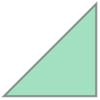

In [5]:
from shapely.geometry import Point
from shapely.geometry.polygon import Polygon
from shapely.geometry.multipolygon import MultiPolygon
from shapely.geometry import MultiPoint, MultiLineString, MultiPolygon, LineString

point = Point(1,2)
points = [(0, 0), (1, 1), (2, 2), (2,0)]
polygon = Polygon(points)
polygon




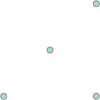

In [6]:
multipoint = MultiPoint(points)
multipoint

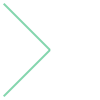

In [7]:
linestrings = [LineString([(0,0), (1, 1)]), LineString([(1, 1), (0, 2)])]
multilinestring = MultiLineString(linestrings)
multilinestring

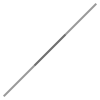

In [8]:
polygons = [Polygon([(0,0), (1, 1), (2, 2)]), Polygon([(1, 1), (2, 2), (3, 3)])]
multipolygon = MultiPolygon(polygons)
multipolygon

In [9]:
polygon_area = polygon.area
polygon_area


2.0

In [10]:
point_bounds = point.bounds
print(f"Point bounds: {point_bounds}")
print(f"Point centroid: {point.centroid}")


Point bounds: (1.0, 2.0, 1.0, 2.0)
Point centroid: POINT (1 2)


In [11]:
# union: Computes the geometric union of two objects.
# intersection: Computes the geometric intersection of two objects.
# difference: Computes the geometric difference of two objects.
# contains: whether one geometric object contains another.
# intersects: whether two geometric objects intersect.



polygon1 area: 4.0, polygon2 area: 4.0, polygon_union area: 7.0


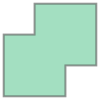

In [12]:
polygon1 = Polygon([(0, 0), (0, 2), (2, 2), (2, 0), (0, 0)])
polygon2 = Polygon([(1, 1), (1, 3), (3, 3), (3, 1), (1, 1)])

# Union of two polygons
polygon_union = polygon1.union(polygon2)
print(f"polygon1 area: {polygon1.area}, polygon2 area: {polygon2.area}, polygon_union area: {polygon_union.area}")
polygon_union

In [13]:
polygon_intersection = lambda polygon1, polygon2: polygon1.intersection(polygon2)
intersection_area = polygon_intersection(polygon1, polygon2).area
print(f"polygon1 area: {polygon1.area}, polygon2 area: {polygon2.area}, intersection area: {intersection_area}")


polygon1 area: 4.0, polygon2 area: 4.0, intersection area: 1.0


In [14]:
#  A bunch of points
point1 = Point(0, 0)
point2 = Point(0, 0)
point3 = Point(1, 1)

# One linestring (connected points)
linestring = LineString([(0, 0), (1, 1), (2, 2)])

# Two polygons
polygon1 = Polygon([(0, 0), (0, 2), (2, 2), (2, 0), (0, 0)])
polygon2 = Polygon([(1, 1), (1, 3), (3, 3), (3, 1), (1, 1)])

# Spatial relationship predicates
print("point1 equals point2:", point1.equals(point2))
print("point1 within polygon1:", point1.within(polygon1))
print("polygon1 intersects polygon2:", polygon1.intersects(polygon2))
print("polygon1 touches polygon2:", polygon1.touches(polygon2))

point1 equals point2: True
point1 within polygon1: False
polygon1 intersects polygon2: True
polygon1 touches polygon2: False


In [15]:
import geopandas as gpd

countries = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
countries.head()

<ipython-input-15-732c915738c6>:3: FutureWarning: The geopandas.dataset module is deprecated and will be removed in GeoPandas 1.0. You can get the original 'naturalearth_lowres' data from https://www.naturalearthdata.com/downloads/110m-cultural-vectors/.
  countries = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))


,pop_est,continent,name,iso_a3,gdp_md_est,geometry
0,889953.0,Oceania,Fiji,FJI,5496,"MULTIPOLYGON (((180.00000 -16.06713, 180.00000..."
1,58005463.0,Africa,Tanzania,TZA,63177,"POLYGON ((33.90371 -0.95000, 34.07262 -1.05982..."
2,603253.0,Africa,W. Sahara,ESH,907,"POLYGON ((-8.66559 27.65643, -8.66512 27.58948..."
3,37589262.0,North America,Canada,CAN,1736425,"MULTIPOLYGON (((-122.84000 49.00000, -122.9742..."
4,328239523.0,North America,United States of America,USA,21433226,"MULTIPOLYGON (((-122.84000 49.00000, -120.0000..."


In [16]:
countries.info(
)

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 177 entries, 0 to 176
Data columns (total 6 columns):
 #   Column      Non-Null Count  Dtype   
---  ------      --------------  -----   
 0   pop_est     177 non-null    float64 
 1   continent   177 non-null    object  
 2   name        177 non-null    object  
 3   iso_a3      177 non-null    object  
 4   gdp_md_est  177 non-null    int64   
 5   geometry    177 non-null    geometry
dtypes: float64(1), geometry(1), int64(1), object(3)
memory usage: 8.4+ KB


In [17]:
countries.crs

<Geographic 2D CRS: EPSG:4326>
Name: WGS 84
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: World.
- bounds: (-180.0, -90.0, 180.0, 90.0)
Datum: World Geodetic System 1984 ensemble
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

<Axes: >

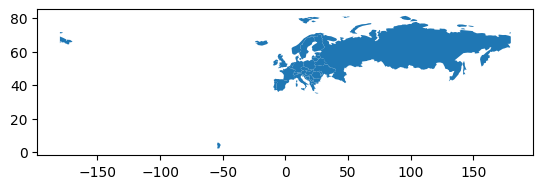

In [18]:
countries[countries["continent"] == "Europe"].plot()

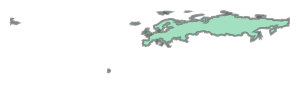

In [19]:
countries[countries["continent"] == "Europe"].unary_union

## Raster

In [20]:
import rioxarray as rxr

ds = rxr.open_rasterio(data_dir / "elevation.tiff")
ds

<xarray.DataArray (band: 1, y: 3601, x: 3601)>
[12967201 values with dtype=int16]
Coordinates:
  * band         (band) int64 1
  * x            (x) float64 36.0 36.0 36.0 36.0 36.0 ... 37.0 37.0 37.0 37.0
  * y            (y) float64 -1.0 -1.0 -1.001 -1.001 ... -1.999 -1.999 -2.0 -2.0
    spatial_ref  int64 0
Attributes: (12/27)
    AREA_OR_POINT:                Point
    DTED_CompilationDate:         2
    DTED_DataEdition:             2
    DTED_DigitizingSystem:        SRTM      
    DTED_HorizontalAccuracy:      12
    DTED_HorizontalDatum:         WGS84
    ...                           ...
    DTED_VerticalAccuracy_UHL:    6
    DTED_VerticalDatum:           E96
    _FillValue:                   -32767
    scale_factor:                 1.0
    add_offset:                   0.0
    units:                        m

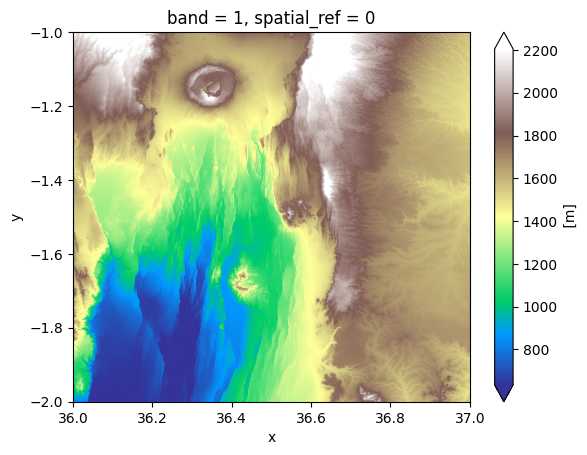

In [21]:
# Visualize the array
_ = ds.plot(robust=True, cmap="terrain")

## Trying to Classify Crop Types in Africa using Geospatial ML

Type of ML problem: supervised multiclass classification problem

Inputs: pixel-level Sentinel-2 satellite imagery
- This includes 12 bands of observations from Snetinel-2 L2A
    - observations in ultra-blue, blue, green, red; visible and near-infrared (VNIR); and short wave infrared (SWIR) spectra, as well as a cloud probability layer

What we're predicting:
We need to classify each farm into one of the following categories:

| Crop ID | Crop Type                      |
|---------|--------------------------------|
|    1    | Maize                          |
|    2    | Cassava                        |
|    3    | Common Bean                    |
|    4    | Maize & Common Bean (intercropping)   |
|    5    | Maize & Cassava (intercropping)       |
|    6    | Maize & Soybean (intercropping)       |
|    7    | Cassava & Common Bean (intercropping) |


Validation Method:
- Random-train-validation split by farm IDs

Evaluation Metric:
- Cross-entropy

## LightGBM Model

Steps:
- Remove the pixels where the cloud probability value is greater than 50%.
- Split the data into train/validation/test.
- Verify that no data leakage is present in the train/validation/test data.
- Check the distribution of each channel or band.
- Plot the farms by their labels in a map.
- Visualize a single farm's NDVI as it changes through time (13 dates).



In [28]:
import pandas as pd

df = pd.read_feather( data_dir / "df.feather")
df.head()



band,time,lat,lon,field,crop,B01,B02,B03,B04,B05,B06,B07,B08,B09,B11,B12,B8A,CLD
0,2019-06-06,0.168064,34.042872,2067,0,0.0192,0.0397,0.0722,0.0520,0.1063,0.2664,0.3255,0.3292,0.1973,0.1044,0.3425,0.3312,0.0
1,2019-06-06,0.168064,34.042962,2067,0,0.0192,0.0402,0.0700,0.0468,0.1085,0.3042,0.3770,0.3372,0.2088,0.1107,0.3929,0.3312,0.0
2,2019-06-06,0.168064,34.043411,1020,2,0.0248,0.0286,0.0673,0.0395,0.1144,0.3462,0.4254,0.4288,0.2325,0.1281,0.4477,0.3812,0.0
3,2019-06-06,0.168064,34.043501,1020,2,0.0248,0.0268,0.0583,0.0321,0.1085,0.3404,0.4207,0.4640,0.2368,0.1403,0.4400,0.3812,0.0
4,2019-06-06,0.168064,34.043591,1020,2,0.0248,0.0256,0.0559,0.0368,0.1085,0.3404,0.4207,0.4540,0.2368,0.1403,0.4400,0.3812,0.0


In [29]:
data_entry_to_visualize = df.iloc[0]  # Selecting the first row as an example
print(data_entry_to_visualize)

band
time     2019-06-06 00:00:00
lat                 0.168064
lon                34.042872
field                   2067
crop                       0
B01                   0.0192
B02                   0.0397
B03                   0.0722
B04                    0.052
B05                   0.1063
B06                   0.2664
B07                   0.3255
B08                   0.3292
B09                   0.1973
B11                   0.1044
B12                   0.3425
B8A                   0.3312
CLD                      0.0
Name: 0, dtype: object


In [30]:
import warnings
import geopandas as gpd
from shapely.geometry import Point

report = df.copy()
report = report.sample(frac = 1)
report = report[["field", "lat", "lon"]].drop_duplicates()
report = gpd.GeoDataFrame(report, geometry  = [Point(xy) for xy in zip(report.lon, report.lat)])
report = report[["field", "geometry"]].drop_duplicates(subset="field")

report.head()

band,field,geometry
630895,936,POINT (34.22062 0.53330)
725551,724,POINT (34.29467 0.59987)
544110,2971,POINT (34.12204 0.39057)
38385,1397,POINT (34.30537 0.56748)
607450,56,POINT (34.34598 0.70388)


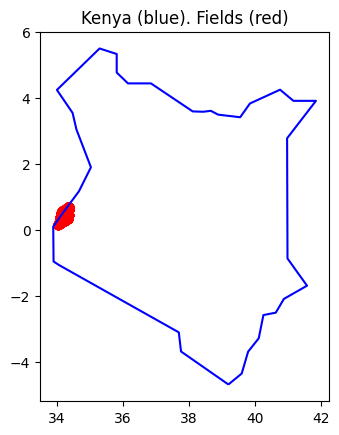

In [31]:
# Get Kenya
with warnings.catch_warnings():
  warnings.filterwarnings("ignore", category=FutureWarning)
  world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
kenya = world[world['name'] == 'Kenya']

# Plot Kenya and our fields
fig, ax = plt.subplots()
_ = kenya.boundary.plot(ax=ax, color="blue")
_ = report.plot(ax=ax, color="red")
ax.set_title("Kenya (blue). Fields (red)")
plt.show()

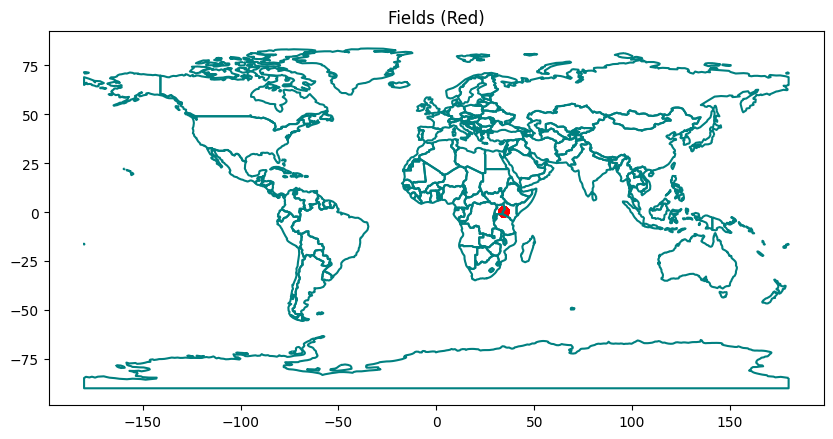

In [33]:
fig, ax = plt.subplots(figsize=(10, 7))
_ = world.boundary.plot(ax=ax, color="teal")
_ = report.plot(ax=ax, color="red")
ax.set_title("Fields (Red)")
plt.show()

In [34]:
# Drop pixels that have a cloud cover greater than 50
df = df[df["CLD"] < 50]

# No need to keep the `CLD` column anymore
df = df.drop(columns=["CLD"])

In [37]:
import numpy as np


# to check if any missing values
answer = np.any(df.isna())



In [39]:
np.random.seed(42)

deploy_crop_id = 0
deploy = df[df["crop"] == deploy_crop_id]

# Train/Validation/Test are the remaining rows
train_val_test = df[~df["field"].isin(deploy["field"])]

# Get the unique field IDs from the train/validation/Test rows
train_val_test_field_ids = train_val_test["field"].sample(frac=1).unique()

# Randomly select 80/10/10 split for train/val/test
val_field_ids = np.random.choice(train_val_test_field_ids, size=int(len(train_val_test_field_ids) * 0.1), replace=False)
test_field_ids = np.random.choice(list(set(train_val_test_field_ids) - set(val_field_ids)), size=int(len(train_val_test_field_ids) * 0.1), replace=False)
train_field_ids = list(set(train_val_test_field_ids) - set(val_field_ids) - set(test_field_ids))

# Create `train`, `val`, and `test` sets based on the validation field IDs
train = train_val_test[train_val_test["field"].isin(train_field_ids)]
val = train_val_test[train_val_test["field"].isin(val_field_ids)]
test = train_val_test[train_val_test["field"].isin(test_field_ids)]

# print the shapes of the train/val/test sets
train.shape, val.shape, test.shape

((475014, 17), (59183, 17), (64530, 17))

In [41]:
# Verify that the sets of field IDs from `train`, `val`, and `test` are mutually exclusive
assert len(set(train["field"].unique()).intersection(set(val["field"].unique()))) == 0
assert len(set(train["field"].unique()).intersection(set(test["field"].unique()))) == 0
assert len(set(val["field"].unique()).intersection(set(test["field"].unique()))) == 0

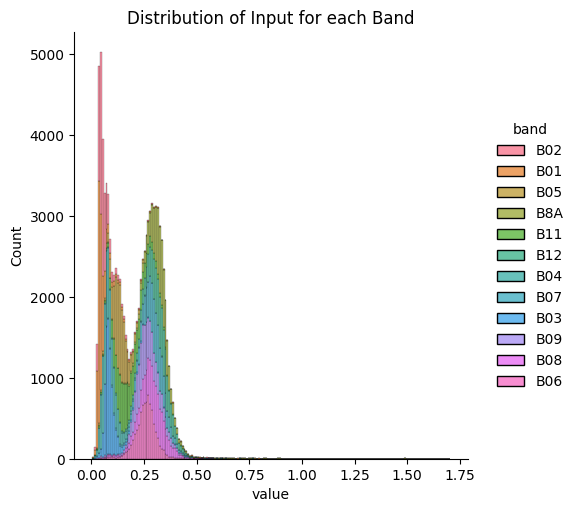

In [42]:
import matplotlib.pyplot as plt
import seaborn as sns

g = sns.displot(data=train.drop(columns=["time", "lat", "lon", "field", "crop"]).melt().sample(100_000), x='value', hue="band", multiple='stack')
plt.title('Distribution of Input for each Band')
plt.show()

AttributeError: Stamen

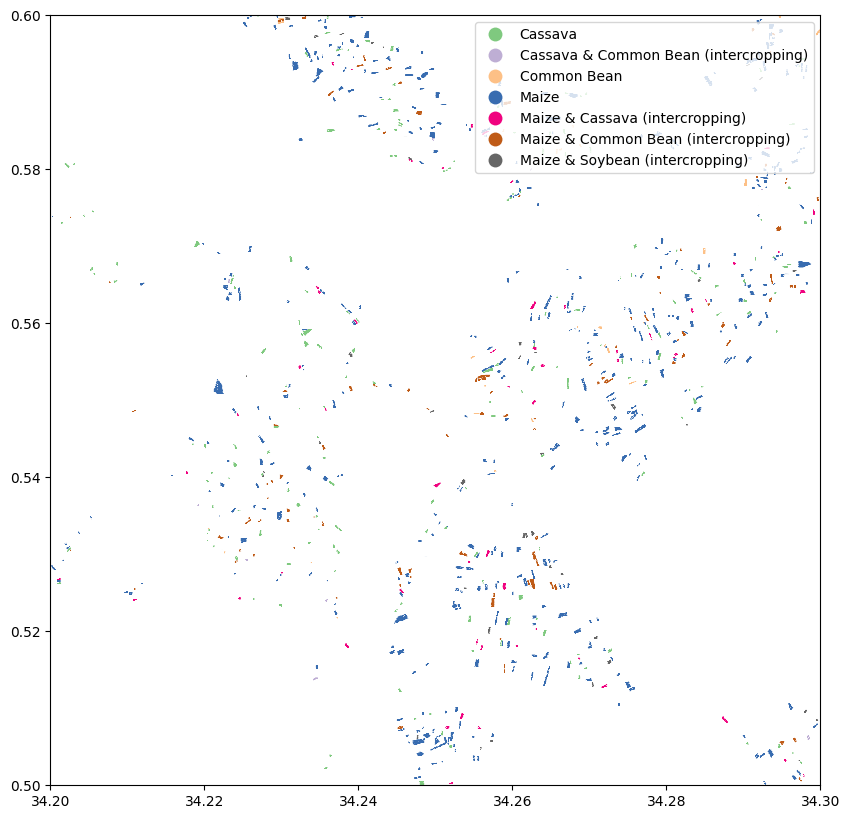

In [43]:
import contextily as ctx
from shapely.geometry import Polygon

# Create a new GeoDataFrame
d = train[["field", "lon", "lat", "crop"]].copy()

# Map crop IDs to names
id_to_name = {
    1: 'Maize',
    2: 'Cassava',
    3: 'Common Bean',
    4: 'Maize & Common Bean (intercropping)',
    5: 'Maize & Cassava (intercropping)',
    6: 'Maize & Soybean (intercropping)',
    7: 'Cassava & Common Bean (intercropping)',
}

# Replace the 'crop' column with mapped names
d['crop'] = d['crop'].map(id_to_name)

# Group by field and crop, and create polygons from point coordinates
polygons = d.groupby(['field', 'crop']).apply(lambda df: Polygon(zip(df.lon, df.lat))).reset_index()
polygons.columns = ['field', 'crop', 'geometry']

# Create a GeoDataFrame
gdf = gpd.GeoDataFrame(polygons, geometry='geometry', crs="EPSG:4326")

# Create a figure and an axes object
fig, ax = plt.subplots(figsize=(10, 10))

# Plot the GeoDataFrame using the 'crop' column to color the polygons
gdf.plot(column="crop", legend=True, ax=ax, cmap="Accent")

# TODO: comment to check the spatial coverage of all training labels
ax.set_xlim([34.2, 34.3])
ax.set_ylim([.5, .6])

# Add a basemap
ctx.add_basemap(ax, crs=gdf.crs.to_string(), source=ctx.providers.Stamen.Terrain)

# Show the plot
plt.show()

/usr/local/lib/python3.10/dist-packages/xarray/core/duck_array_ops.py:188: RuntimeWarning: invalid value encountered in cast
  return data.astype(dtype, **kwargs)


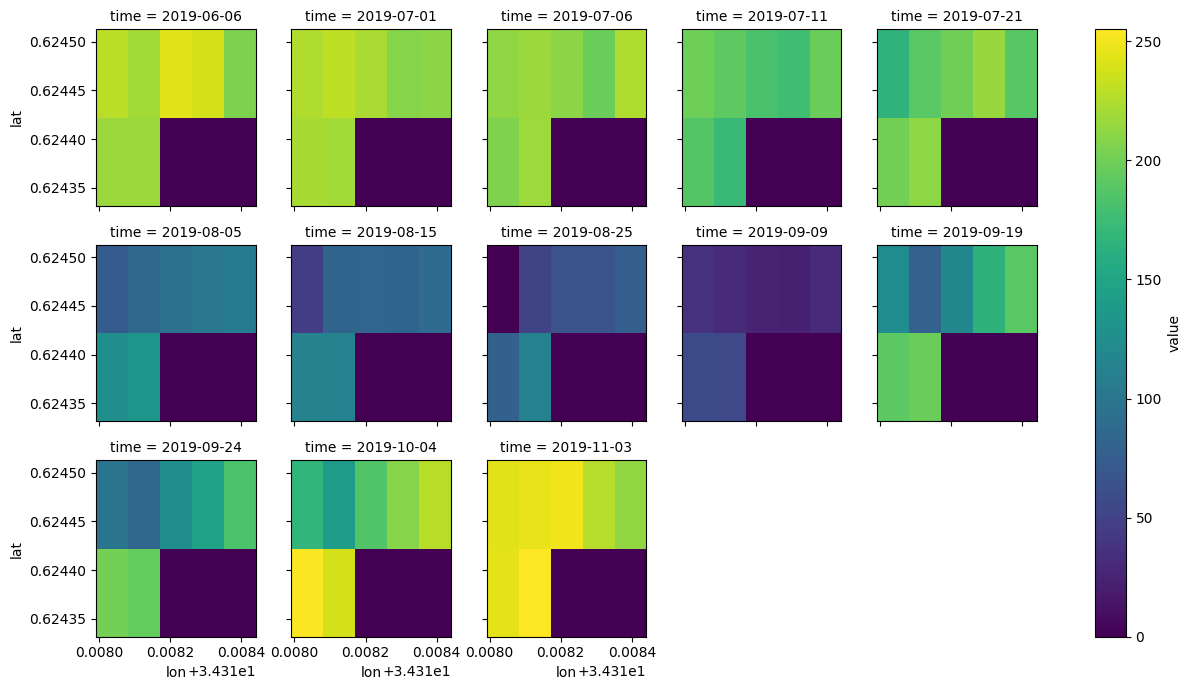

In [44]:
from random import choice

d = train.copy()
field_id = choice(d["field"].unique().tolist())
d = d.loc[d["field"] == field_id]
d = d[["time", "lat", "lon", "B08", "B04"]]
d = d.melt(id_vars=["time", "lat", "lon"], value_vars=["B08", "B04"], var_name="band", value_name="value")
d = d.set_index(["time", "lat", "lon", "band"])
d = d.to_xarray()

# Calculate NDVI and assign to 'value'
d = (d.sel(band='B08') - d.sel(band='B04')) / (d.sel(band='B08') + d.sel(band='B04'))

# Normalize NDVI to the range 0-255
d = (d.apply(lambda x: (x - x.min()) / (x.max() - x.min())) * 255).astype("uint8")

# Plot the field (each column should represent a time)
_ = d["value"].plot.imshow(col="time", x="lon", y="lat", col_wrap=5, figsize=(13, 7))

## Deep Learning Model

In [46]:
#@title Implement the `__len__` and `__getitem__` methods
class FieldSequenceDataset(Dataset):
    """
    A dataset class for sequences of field images.

    Attributes:
    - X: Numpy array containing image sequences.
    - y: Labels associated with each image sequence.
    - classes: List of class names/labels.
    - transforms: Optional data augmentation operations.

    Methods:
    - __len__ : Returns the length of the dataset.
    - __getitem__ : Fetches a data sample for a given index.
    - plot: Plots an image sequence from a given sample.
    """

    def __init__(
        self,
        X,
        y,
        field_ids: List[int],
        transforms: Optional[Callable] = None
    ) -> None:
        """
        Initializes the dataset object.

        Parameters:
        - X: Numpy array containing image sequences of shape (num_samples, num_images, height, width, bands).
        - y: Numpy array containing labels for each sequence.
        - field_ids: List of indices to subset the dataset. Defaults to None (use all data).
        - transforms: Optional data augmentation operations.
        """

        # Define class labels
        self.classes = [str(i) for i in range(1, 8)]

        # Instead of slicing the data, store the indices
        self.field_ids = field_ids
        self.X = X
        self.y = y

        # Set the data augmentation transforms
        self.transforms = transforms

    def __len__(self) -> int:
        """Returns the number of samples in the dataset."""
        return len(self.field_ids)

    def __getitem__(self, index: int) -> dict[str, torch.Tensor]:
        """
        Returns a data sample given an index.

        Parameters:
        - index: Index of the sample to fetch.

        Returns:
        Dictionary containing the image sequence and its associated label.
        """
        #  Use the field_ids to fetch the relevant data
        sequence = self.X[self.field_ids[index]]
        label = self.y[self.field_ids[index]]

        # Convert them to PyTorch tensors
        sample = {'image': torch.tensor(sequence, dtype=torch.float32), 'label': torch.tensor(label, dtype=torch.long)}

        return sample
    def plot(
        self,
        sample: Dict[str, Any],
        show_titles: bool = True,
        suptitle: Optional[str] = None,
    ) -> plt.Figure:
        """
        Plots an image sequence from a sample.

        Parameters:
        - sample: Dictionary containing an image sequence and its label.
        - show_titles: Whether to display titles on the plots.
        - suptitle: Optional overarching title for the entire plot.

        Returns:
        Matplotlib figure object.
        """

        # Extract and normalize image sequence
        sequence = sample['image'].numpy()[:, [3, 2, 1], :, :]
        label = sample['label'].item()
        min_vals = sequence.min(axis=(0, 2, 3), keepdims=True)
        max_vals = sequence.max(axis=(0, 2, 3), keepdims=True)
        sequence = (sequence - min_vals) / (max_vals - min_vals)

        # Calculate layout for plotting multiple images
        num_images = sequence.shape[0]
        num_rows = int(np.ceil(num_images / 4.0))

        # Create a figure and plot each image in the sequence
        fig, axarr = plt.subplots(num_rows, 4, figsize=(15, 4 * num_rows))
        if num_rows == 1:
            axarr = np.expand_dims(axarr, axis=0)
        for i in range(num_rows):
            for j in range(4):
                idx = i * 4 + j
                if idx < num_images:
                    ax = axarr[i, j]
                    ax.imshow(sequence[idx].transpose(1, 2, 0))
                    ax.axis('off')
                    if show_titles and idx == num_images - 1:
                        ax.set_title(f'Label: {self.classes[label]}')
                else:
                    axarr[i, j].axis('off')

        # Set the optional overarching title
        if suptitle:
            fig.suptitle(suptitle, fontsize=16)

        return fig

Training Set, Validation Set, Test Set


In [48]:
class FieldDataModule(LightningDataModule):
    """
    PyTorch Lightning data module for handling field sequence data.

    This class helps in loading and splitting the dataset into train, validation, and test sets.

    Attributes:
    - root: The path to the root directory containing the data.
    - batch_size: Size of the batches during training.
    - workers: Number of workers for data loading.
    - X: Numpy array containing image sequences.
    - y: Numpy array containing labels for each sequence.
    - train_ids, val_ids, test_ids: Lists containing indices for the train, validation, and test splits respectively.
    - train_ds, val_ds, test_ds: Dataset objects for the train, validation, and test sets.
    """

    def __init__(
        self,
        root: str,
        train_size: float = 0.8,
        val_size: float = 0.1,
        test_size: float = 0.1,
        batch_size: int = 8,
        workers: int = 4,
    ):
        super().__init__()

        # Define directory path and loading configurations
        self.root = Path(root)
        self.batch_size = batch_size
        self.workers = workers

        # Load the dataset into memory
        self.X = np.load(self.root / "X.npy")
        self.y = np.load(self.root / "y.npy")

        # Randomly shuffle field IDs for dataset split
        all_field_ids = list(range(3280))
        shuffle(all_field_ids)

        # Split the dataset into train, validation, and test sets based on provided ratios
        self.train_ids, temp_ids = train_test_split(all_field_ids, test_size=1 - train_size, random_state=42)
        self.val_ids, self.test_ids = train_test_split(temp_ids, test_size=test_size / (test_size + val_size), random_state=42)

        # Setup datasets
        self.setup()

    def setup(self, stage=None):
        """
        Prepare datasets for training, validation, and testing.

        Uses the field IDs generated during initialization to subset the full dataset.
        """
        self.train_ds = FieldSequenceDataset(self.X[self.train_ids], self.y[self.train_ids])
        self.val_ds = FieldSequenceDataset(self.X[self.val_ids], self.y[self.val_ids])
        self.test_ds = FieldSequenceDataset(self.X[self.test_ids], self.y[self.test_ids])

    def train_dataloader(self):
        """Returns a DataLoader object for the training dataset."""

        return DataLoader(self.train_ds, batch_size = self.batch_size, num_workers = self.workers, shuffle  = True)

    def val_dataloader(self):
        """Returns a DataLoader object for the validation dataset."""

        return DataLoader(self.val_ds, batch_size = self.batch_size, num_workers = self.workers)

    def test_dataloader(self):
        """Returns a DataLoader object for the test dataset."""
        return DataLoader(self.test_ds, batch_size = self.batch_size, num_workers = self.workers)

Model Architecture

*  **ResNet18 Encoder** (basically extracts the important features from each image)
  
  * *Think of this as converting a detailed image into a summarized version that retains all the essential information.*

* **Bidirectional GRU**: Once we have the features for each image in the sequence, this component helps the model understand the order and relationship between these images. It looks at the sequence forwards and backwards, ensuring it captures patterns that emerge over time.
* FC Layer


In [49]:
def ResNet18(in_channels, input_size):
    return timm.create_model('resnet18', pretrained=True, in_channels=in_channels, num_classes=input_size)

In [52]:
class SequenceClassificationModel(nn.Module):
    """
    Neural network model for sequence classification tasks.

    This model consists of a ResNet18 encoder, a bidirectional GRU, and a fully connected classifier.
    Given an input sequence of images, it outputs class probabilities for each sequence.

    Attributes:
    - encoder: ResNet18 encoder for feature extraction from each image in the sequence.
    - gru: Bidirectional GRU to model temporal dependencies in the sequence of features.
    - fc: Fully connected layer to produce class probabilities.
    """

    def __init__(self, in_channels, input_size, hidden_size, num_layers, num_classes):
        super(SequenceClassificationModel, self).__init__()

        self.encoder = ResNet18(in_channels, input_size)
        self.gru = nn.GRU(input_size, hidden_size, num_layers, batch_first=True, bidirectional=True) # for modeling sequences

        self.fc = nn.Linear(hidden_size * 2, num_classes) # for outputting class probabilities
    def forward(self, x : torch.Tensor) -> torch.Tensor:
        """
        Forward pass of the model.

        Args:
        - x (torch.Tensor): Input tensor of shape (batch_size, sequence_length, channels, height, width).

        Returns:
        - torch.Tensor: Output tensor of class probabilities with shape (batch_size, num_classes).
        """
        batch_size, sequence_length, channels, height, width = x.shape
        x = x.view(batch_size * sequence_length, channels, height, width)
        x = self.encoder(x)
        x = x.view(batch_size, sequence_length, -1)
        x, _ = self.gru(x)
        x = x[:, -1, :]
        x = self.fc(x)
        return x


In [53]:
class SequenceAugmentationPipeline(nn.Module):
    """
    A data augmentation pipeline for sequences of images.

    This module defines a set of transformations that are applied consistently across
    all images in a sequence. This ensures that the spatial relationship between
    images in a sequence remains consistent after augmentation.

    Attributes:
    - hflip: Random horizontal flip transformation.
    - vflip: Random vertical flip transformation.
    - rotate: Random rotation transformation.
    """

    def __init__(self) -> None:
        """
        Initialize the augmentation pipeline with desired transformations.
        """
        super(SequenceAugmentationPipeline, self).__init__()

        self.hflip = K.RandomHorizontalFlip()
        self.vflip = K.RandomVerticalFlip()
        self.rotate = K.RandomRotation(degrees=30)

    def forward(self, input: torch.Tensor) -> torch.Tensor:
        """
        Apply the transformations consistently across each image in the sequence.

        Parameters:
        - input (torch.Tensor): Input tensor of shape (batch_size, sequence_length, bands, height, width).

        Returns:
        - torch.Tensor: Augmented tensor with the same shape as input.
        """
        # Extract the shape parameters for the transformations from the first image
        # in the sequence. This ensures consistent augmentation across all images.
        hflip_params = self.hflip.forward_parameters(input[:, 0, ...].shape)
        vflip_params = self.vflip.forward_parameters(input[:, 0, ...].shape)
        rotate_params = self.rotate.forward_parameters(input[:, 0, ...].shape)

        # Apply the transformations to each image in the sequence.
        transformed_seq = []
        for image in input.unbind(dim=1):
            image = self.hflip(image, hflip_params)
            image = self.vflip(image, vflip_params)
            image = self.rotate(image, rotate_params)
            transformed_seq.append(image)

        # Combine the transformed images back into the sequence format.
        output = torch.stack(transformed_seq, dim=1)

        return output


In [54]:
class SequenceClassificationTask(LightningModule):
    """
    Lightning module for the sequence classification task.

    This module wraps the SequenceClassificationModel for training, validation, and testing.
    It also handles data augmentation using the SequenceAugmentationPipeline.

    Attributes:
    - model: The sequence classification model.
    - loss_fn: Loss function for classification.
    - learning_rate: Learning rate for the optimizer.
    - aug: Data augmentation pipeline for training sequences.
    """

    def __init__(self, input_size, hidden_size, in_channels=14, num_layers=3, num_classes=7, learning_rate=0.001):
        """
        Initialize the lightning module.

        Parameters:
        - input_size (int): Size of the input to the GRU.
        - hidden_size (int): Size of the GRU hidden state.
        - in_channels (int, optional): Number of input channels to the model. Defaults to 14.
        - num_layers (int, optional): Number of GRU layers. Defaults to 3.
        - num_classes (int, optional): Number of classification classes. Defaults to 7.
        - learning_rate (float, optional): Learning rate for the optimizer. Defaults to 0.001.
        """
        super(SequenceClassificationTask, self).__init__()

        self.model = SequenceClassificationModel(in_channels, input_size, hidden_size, num_layers, num_classes)
        self.loss_fn = nn.CrossEntropyLoss()
        self.learning_rate = learning_rate

        # Define the data augmentation pipeline for training.
        self.aug = SequenceAugmentationPipeline()

    def forward(self, x):
        """
        Forward pass through the model.

        Parameters:
        - x (torch.Tensor): Input tensor.

        Returns:
        - torch.Tensor: Model predictions.
        """
        return self.model(x)

    def training_step(self, batch, batch_idx):
        """
        Defines a single step during training.

        Parameters:
        - batch (dict): Batch of data.
        - batch_idx (int): Index of the batch.

        Returns:
        - torch.Tensor: Training loss.
        """
        x, y = batch["image"], batch["label"]

        # Apply data augmentation to the training data.
        x = self.aug(x)

        logits = self(x)
        loss = self.loss_fn(logits, y)

        # Log training loss to TensorBoard.
        self.log("train_loss", loss)

        return loss

    def validation_step(self, batch, batch_idx):
        """
        Defines a single step during validation.

        Parameters:
        - batch (dict): Batch of data.
        - batch_idx (int): Index of the batch.

        Returns:
        - torch.Tensor: Validation loss.
        """
        x, y = batch["image"], batch["label"]
        logits = self(x)
        loss = self.loss_fn(logits, y)

        # Log validation loss to TensorBoard.
        self.log("val_loss", loss)

        return loss

    def test_step(self, batch, batch_idx):
        """
        Defines a single step during testing.

        Parameters:
        - batch (dict): Batch of data.
        - batch_idx (int): Index of the batch.

        Returns:
        - torch.Tensor: Testing loss.
        """
        x, y = batch["image"], batch["label"]
        logits = self(x)
        loss = self.loss_fn(logits, y)

        # Log testing loss to TensorBoard.
        self.log("test_loss", loss)

        return loss

    def configure_optimizers(self):
        """
        Configures the optimizer(s) and learning rate scheduler(s).

        Returns:
        - Dict: Contains optimizer and learning rate scheduler information.
        """
        optimizer = torch.optim.AdamW(self.model.parameters(), lr=self.learning_rate)

        # Define a learning rate scheduler that reduces the learning rate when the validation loss plateaus.
        scheduler = ReduceLROnPlateau(optimizer, patience=5)

        return {
            "optimizer": optimizer,
            "lr_scheduler": {
                "scheduler": scheduler,
                "monitor": "val_loss",
            },
        }

In [55]:
# Set training config
root = "./files"
experiment_name = "seq2one-poc"
gpu = 0
min_epochs, max_epochs = 3, 30

# Set the hyperparameters
batch_size = 64
learning_rate = 0.001
hidden_size = 128
num_layers = 3
early_stopping_patience = 15

In [57]:
dm = FieldDataModule(root=root, batch_size=batch_size, workers=2)


FileNotFoundError: [Errno 2] No such file or directory: 'files/X.npy'

In [58]:
# Create the task with the sampled hyperparameters
task = SequenceClassificationTask(input_size=512,
                                  hidden_size=hidden_size,
                                  num_layers=num_layers,
                                  learning_rate=learning_rate)

# Create a dedicated models' directory for saving the trial's best models
models_path = Path(f"./models/{experiment_name}/")
models_path.mkdir(parents=True, exist_ok=True)

# Set the callbacks
checkpoint_callback = ModelCheckpoint(
    monitor="val_loss",
    dirpath=models_path,
    filename=f"model-{{epoch:02d}}-{{val_loss:.2f}}",
    save_top_k=1,
    mode="min",
)
early_stopping_callback = EarlyStopping(monitor="val_loss",
                                        mode="min",
                                        patience=early_stopping_patience)

# Create a TensorBoard logger
logger = TensorBoardLogger("./tb_logs", name=experiment_name)

# Trainer definition
trainer = Trainer(
    logger=logger,
    accelerator='gpu',
    devices=[gpu],
    max_epochs=max_epochs,
    min_epochs=min_epochs,
    callbacks=[checkpoint_callback, early_stopping_callback],
    precision=16
)

trainer.fit(model=task, datamodule=dm)

TypeError: ResNet.__init__() got an unexpected keyword argument 'in_channels'

In [59]:
checkpoint_callback.best_model_score.item()


NameError: name 'checkpoint_callback' is not defined

In [60]:
#  Load your model
model = SequenceClassificationTask.load_from_checkpoint(trainer.checkpoint_callback.best_model_path,
                                                        input_size=512,
                                                        hidden_size=hidden_size)
model.eval()
model.freeze()

# Get the validation data loader
test_dl = dm.test_dataloader()

# Predict
all_logits = []
y_tests = []

with torch.no_grad():
    for batch in test_dl:
        inputs = batch['image']
        y_test = batch['label']
        logits = model(inputs)
        all_logits.append(logits)
        y_tests.append(y_test)

# Concatenate all the results
all_logits = torch.cat(all_logits, dim=0)
y_test = torch.cat(y_tests, dim=0)

# Get the probabilities
y_test_hat = torch.nn.functional.softmax(all_logits, dim=1)

SyntaxError: invalid syntax (<ipython-input-60-3231f11619f5>, line 1)

In [61]:
from sklearn.metrics import log_loss

# Get the arrays
y_test_np = y_test.cpu().numpy()
y_test_hat_np = y_test_hat.cpu().numpy()

# Convert y_val to a binary label indicator format
y_test_bin = label_binarize(y_test_np, classes=[0, 1, 2, 3, 4, 5, 6])

cross_entropy = log_loss(y_test_bin, y_test_hat_np)
print("Cross Entropy:", cross_entropy)

NameError: name 'y_test' is not defined